<a href="https://colab.research.google.com/github/Gabriel-Aspen/chest_xray/blob/main/Chest_Xray_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks')
os.getcwd()

## Table of Contents
###Simple Convnet
- Preprocessing: Open data from csv, resize, Pickle data
- Simple convnet gridsearch
- Class weight gridsearch

###Xception
- Data generator
- Transfer learning
- Naive model + class weight gridsearch

###Evaluating models
- F1 vs Accuracy vs Roc auc 
- Quick file read/evaluate function
- Tensorboard


----------------------------------

#Simple Convnet

##Preprocess data

###Function that reads data

> If you want to see how we got this read the "Exploring the data" section



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle

In [ ]:
DATADIR = '/content/gdrive/My Drive/Colab Notebooks/xray/chest_xray/test'
CATEGORIES = ['NORMAL', 'PNEUMONIA']

def get_data(datadir, categories):
  DATADIR = datadir
  CATEGORIES = categories
  IMG_SIZE = 200

  training_data = []
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path)[:]:
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #grayscale
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass
  random.shuffle(training_data)

  X = []
  y = []
  for features, label in training_data:
    X.append(features)
    y.append(label)
  X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #the last one is because its in grayscale
  with open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/X_test.pickle', 'wb') as pickle_out: #name the X!
    pickle.dump(X, pickle_out)
    pickle_out.close()
  with open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/y_test.pickle', 'wb') as pickle_out: #name the y!
      pickle.dump(y, pickle_out)
      pickle_out.close()
get_data(DATADIR, CATEGORIES)

###Exploring the data

Check out how many images are in each group

In [ ]:
path, dirs, files_pneumonia = next(os.walk('/content/gdrive/My Drive/Colab Notebooks/xray/chest_xray/train/PNEUMONIA'))
pneumonia_count = len(files_pneumonia)
print(pneumonia_count)

path, dirs, files_normal = next(os.walk('/content/gdrive/My Drive/Colab Notebooks/xray/chest_xray/train/NORMAL'))
normal_count = len(files_normal)
print(normal_count)

3895
1357


Take a look at the first image. Sweet loop, we'll use this later

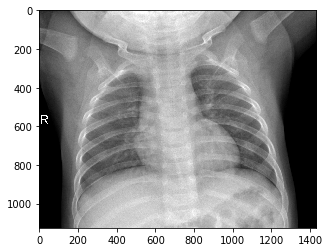

In [ ]:
DATADIR = '/content/gdrive/My Drive/Colab Notebooks/xray/chest_xray/train'
CATEGORIES = ['NORMAL', 'PNEUMONIA']

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #grayscale
    plt.imshow(img_array, cmap='gray')
    plt.show()
    break
  break


In [ ]:
print(img_array.shape)

(1225, 1292)


Play around with the resize. I went with 200

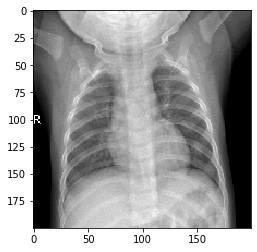

In [ ]:
#resize the image
IMG_SIZE = 200
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap= 'gray')

###Bringing in the data

Use that loop to create the training data, note the images are shrunk using your "IMG_SIZE". 


* I only used the first 500 examples from each category and made them grayscale. Extra 'try' loop just in case files are bad
* For the full training you'll want to use the whole dataset



In [ ]:
#create data
training_data = []
IMG_SIZE = 200

def create_training_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path)[:500]: #first 500
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #grayscale
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        training_data.append([new_array, class_num])
      except Exception as e:
        pass

create_training_data()

In [ ]:
print(len(training_data))

1000


Shuffle it. Its all in order right now.

In [ ]:
#shuffle the data
import random

random.shuffle(training_data)

Pop it into an array and were good to go

In [ ]:
X = []
y = []

In [ ]:
for features, label in training_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) #the last one is because its in grayscale

Pickle it so we dont have to do this again




In [ ]:
#write
import pickle
with open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/X.pickle', 'wb') as pickle_out:
    pickle.dump(X, pickle_out)
    pickle_out.close()
with open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/y.pickle', 'wb') as pickle_out:
    pickle.dump(y, pickle_out)
    pickle_out.close()

In [ ]:
#read
with open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/X.pickle', 'rb') as pickle_in:
    X = pickle.load(pickle_in)
with open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/y.pickle', 'rb') as pickle_in:
    y = pickle.load(pickle_in)

## Simple ConvNet Gridsearch

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

In [ ]:
#train
X = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/X_train_.pickle', 'rb'))
y = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/y_train_.pickle', 'rb'))
X = X/255.

#test
X_test = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/X_test.pickle', 'rb'))
y_test = pickle.load(open('/content/gdrive/My Drive/Colab Notebooks/xray/pickle_files/y_test.pickle', 'rb'))
X_test = X_test/255.

Gridsearch basic structure

In [ ]:
dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

timestamp = int(time.time())

for dense_layer in dense_layers:
  for layer_size in layer_sizes:
    for conv_layer in conv_layers:
      NAME = '{}-conv-{}-nodes-{}-dense{}'.format(conv_layer, layer_size, dense_layer, timestamp)
      tensorboard = TensorBoard(log_dir = 'xray/logs/{}'.format(NAME))
      checkpoint_cb = keras.callbacks.ModelCheckpoint('xray/models/{}.h5'.format(NAME), save_best_only = True)
      early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True)

      model = Sequential()

      model.add(Conv2D(layer_size, (3,3), input_shape = X.shape[1:])) #window of 3x3
      model.add(Activation('relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))

      for l in range(conv_layer-1):
        model.add(Conv2D(layer_size, (3,3))) #window of 3x3
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))

      model.add(Flatten())
      for l in range(dense_layer):
        model.add(Dense(layer_size))
        model.add(Activation('relu'))

      model.add(Dense(1)) 
      model.add(Activation('sigmoid'))

      model.compile(loss='binary_crossentropy',
                    optimizer= 'adam', 
                    metrics = ['accuracy'])
      model.fit(X, y, batch_size=32, epochs = 20, validation_split=0.1, callbacks=[tensorboard, checkpoint_cb, early_stopping_cb])

##Class Weight Gridsearch

If the data is imbalanced- Gridsearch some class weights on the more sucessful models

In [ ]:
weights = np.linspace(0.05, 0.95, 20)

class_weights = {0: weight, 1: 1.0-weight}

NAME = '{}-weight-{}'.format(weight, timestamp)
tensorboard = TensorBoard(log_dir = 'xray/logs/{}'.format(NAME))
checkpoint_cb = keras.callbacks.ModelCheckpoint('xray/models/balanced/{}.h5'.format(NAME), save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights = True)

dense_layer = 0
layer_size = 64
conv_layer = 3

model = Sequential()

model.add(Conv2D(layer_size, (3,3), input_shape = X.shape[1:])) #window of 3x3
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

for l in range(conv_layer-1):
  model.add(Conv2D(layer_size, (3,3))) #window of 3x3
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
for l in range(dense_layer):
  model.add(Dense(layer_size))
  model.add(Activation('relu'))

model.add(Dense(1)) 
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer= 'adam', 
            metrics = ['accuracy'])

model.fit(X, y, batch_size=32, epochs = 10, validation_split=0.1, class_weight= class_weights,
          callbacks=[tensorboard, checkpoint_cb, early_stopping_cb])

Find the best model

In [ ]:
from sklearn.metrics import f1_score

path = ('/content/gdrive/My Drive/Colab Notebooks/xray/models')
def fileList(source):
    matches = []
    for filename in os.listdir(path):
        if filename.endswith(('.h5')):
            matches.append(os.path.join(path, filename))
    return matches
models = fileList(path)
#give f1 score
for model in models:
    clf = keras.models.load_model(model)
    preds = clf.predict(X_test)
    print("{}----{}".format(f1_score(y_test, preds.round()), model))

--------------

#Xception
* This model typically handles 224x224(x3) images- preprocess the data accordingly

###Data generator

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd
import os
import glob
from pathlib import Path
import cv2
from tensorflow.keras.utils import to_categorical


Training data

In [ ]:
data_dir = Path('/content/gdrive/My Drive/Colab Notebooks/xray/chest_xray')

train_dir = data_dir / 'train'

normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []
for img in normal_cases:
    train_data.append((img,0))

for img in pneumonia_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
#randomize
train_data = train_data.sample(frac=1.).reset_index(drop=True)

Validation data

In [ ]:
#validation
val_dir = data_dir / 'val'

normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

valid_data = []
valid_labels = []

# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

Define a data generator: This only affects the under-represented class (normal)
- Horizontal flips
- Rotation
- Random Brightness

In [ ]:
#data generator

# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # rotation
    iaa.Multiply((1.2, 1.5))]) #random brightness

def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

Check out an example batch

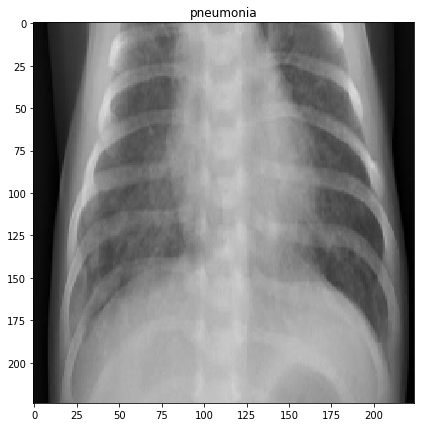

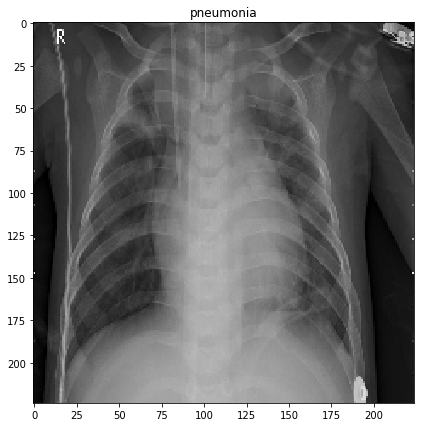

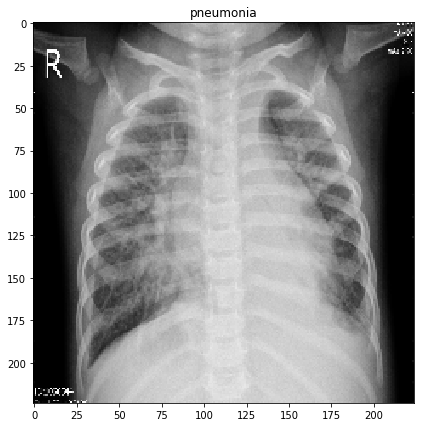

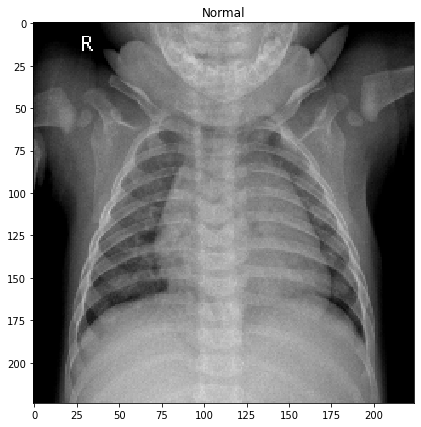

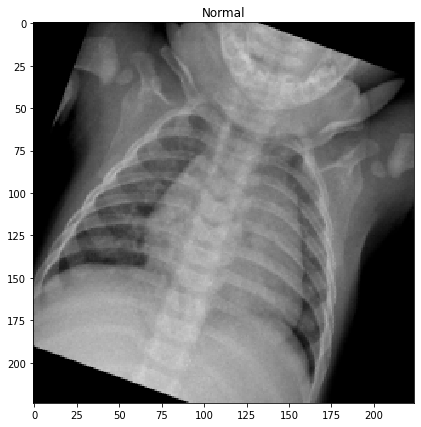

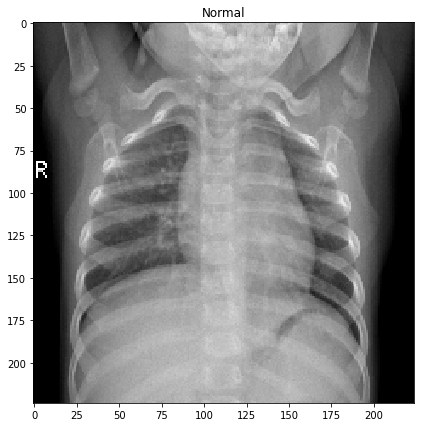

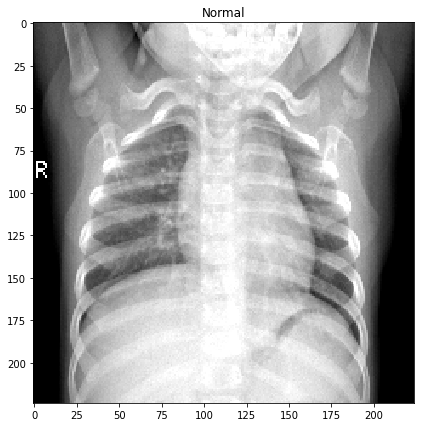

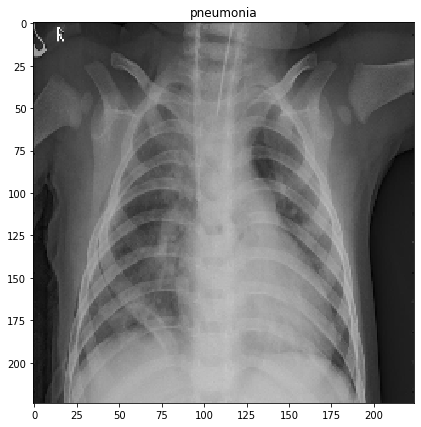

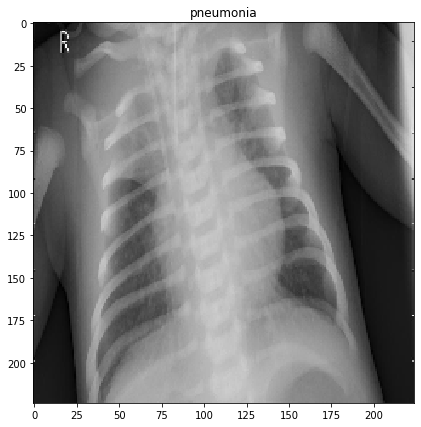

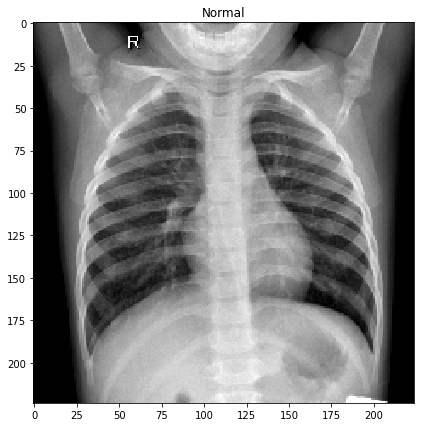

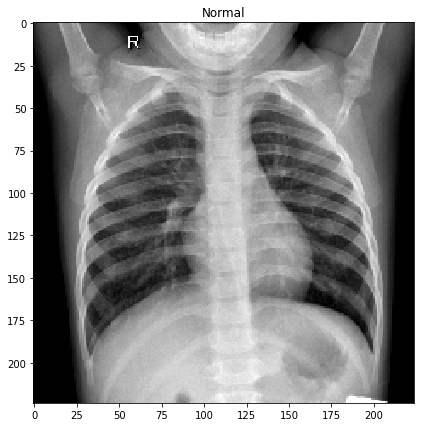

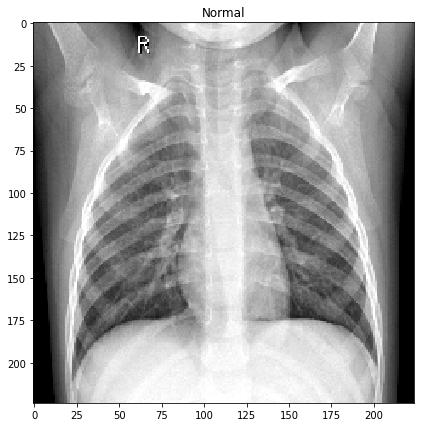

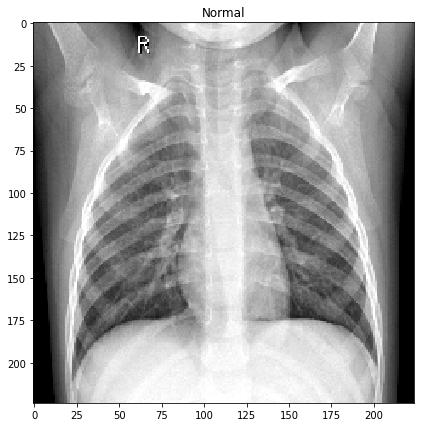

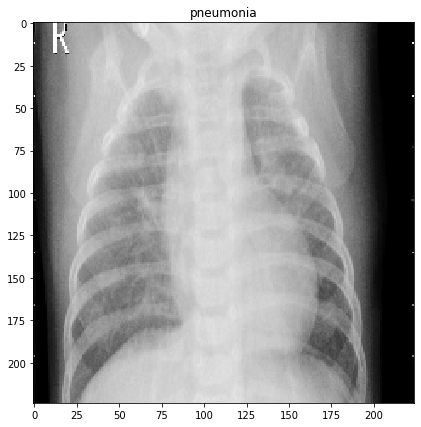

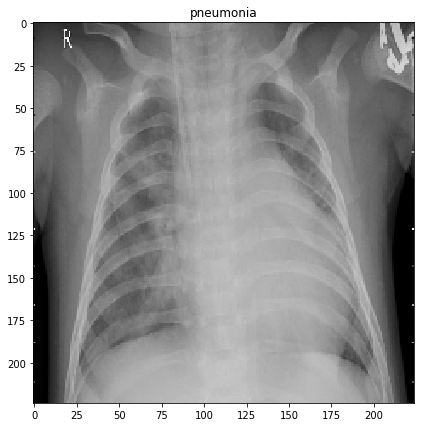

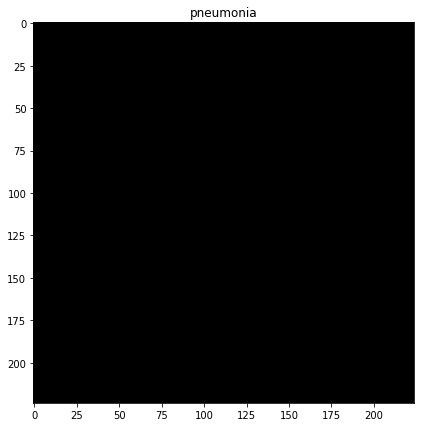

In [ ]:
batch_size = 16
example = next(data_gen(data=train_data, batch_size=batch_size))
for i in range(batch_size):
  f, ax = plt.subplots(figsize=(7,7))
  plt.imshow(example[0][i], interpolation='nearest')
  if example[1][i,0] == 1: # 1 because we one-hot encoded the label, [i,0] is "0" column (normal)
    ax.set_title("Normal")
  else:
    ax.set_title("pneumonia")
  plt.show()

##Transfer learning

Load an Xception model pretrained on imagenet

In [ ]:
#ageron
n_classes = 2
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="sigmoid")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

Create the generator

In [ ]:
train_data_gen = data_gen(data=train_data, batch_size=batch_size)
valid_data_gen = data_gen(data=valid_data, batch_size=batch_size)

batch_size = 16
nb_train_steps = train_data.shape[0]//batch_size # Define the number of training steps

Freeze base layer weights and set a high learning rate. Train for 5 epochs

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=optimizer)

nb_epochs = 5
class_weight={0:1.0, 1:0.4}
es = EarlyStopping(patience=10)
chkpt = ModelCheckpoint(filepath='xray/models/Xception.h5', save_best_only=True, save_weights_only=True)

history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=valid_data_gen, callbacks=[es, chkpt],
                              class_weight=class_weight)

Unfreeze the base layer weights and lower the learning rate. Train for many epochs

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=optimizer)

nb_epochs = 40

history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight=class_weight)

---

#Evaluating models